In [1]:
import os
import random
import numpy as np
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 

Num GPUs Available:  1


In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'C:/Users/Admin/Downloads/stage1_train/'
TEST_PATH = 'C:/Users/Admin/Downloads/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        if not mask_file.endswith('.png'):
            continue  # Skip non-image files like .DS_Store
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_) 
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing training images and masks


100%|██████████| 670/670 [06:48<00:00,  1.64it/s]


Resizing test images


100%|██████████| 65/65 [00:01<00:00, 40.92it/s]

Done!


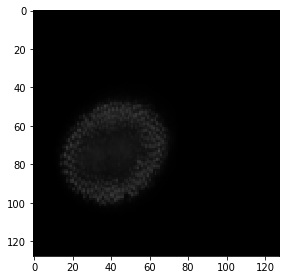

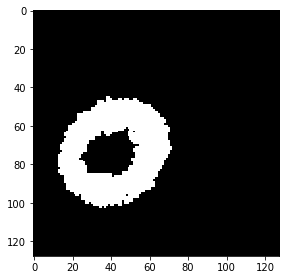

In [4]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [10]:
                                                # UNet++ Model

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, ReLU, Dropout
from tensorflow.keras.models import Model

# Define the input shape
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Define the U-Net model architecture
conv_num = 32

XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(s)
XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE1)
XE1_pool = MaxPooling2D(pool_size=(2, 2))(XE1)

XE2 = Conv2D(conv_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE1_pool)
XE2 = Conv2D(conv_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE2)
XE2_pool = MaxPooling2D(pool_size=(2, 2))(XE2)

XE3 = Conv2D(conv_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE2_pool)
XE3 = Conv2D(conv_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE3)
XE3_pool = MaxPooling2D(pool_size=(2, 2))(XE3)

XE4 = Conv2D(conv_num * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE3_pool)
XE4 = Conv2D(conv_num * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE4)
XE4 = Dropout(0.5)(XE4)
XE4_pool = MaxPooling2D(pool_size=(2, 2))(XE4)

XE5 = Conv2D(conv_num * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE4_pool)
XE5 = Conv2D(conv_num * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE5)
XE5 = Dropout(0.5)(XE5)

XD4_from_XE5 = UpSampling2D(size=(2, 2), interpolation='bilinear')(XE5)
XD4_from_XE5 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4_from_XE5)
XD4_from_XE4 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE4)
XD4_from_XE3 = MaxPooling2D(pool_size=(2, 2))(XE3)
XD4_from_XE3 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4_from_XE3)
XD4_from_XE2 = MaxPooling2D(pool_size=(4, 4))(XE2)
XD4_from_XE2 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4_from_XE2)
XD4_from_XE1 = MaxPooling2D(pool_size=(8, 8))(XE1)
XD4_from_XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4_from_XE1)
XD4 = concatenate([XD4_from_XE5, XD4_from_XE4, XD4_from_XE3, XD4_from_XE2, XD4_from_XE1], axis=-1)
XD4 = Conv2D(320, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4)
XD4 = BatchNormalization()(XD4)
XD4 = ReLU()(XD4)

XD3_from_XE5 = UpSampling2D(size=(4, 4), interpolation='bilinear')(XE5)
XD3_from_XE5 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3_from_XE5)
XD3_from_XD4 = UpSampling2D(size=(2, 2), interpolation='bilinear')(XD4)
XD3_from_XD4 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3_from_XD4)
XD3_from_XE3 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE3)
XD3_from_XE2 = MaxPooling2D(pool_size=(2, 2))(XE2)
XD3_from_XE2 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3_from_XE2)
XD3_from_XE1 = MaxPooling2D(pool_size=(4, 4))(XE1)
XD3_from_XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3_from_XE1)
XD3 = concatenate([XD3_from_XE5, XD3_from_XD4, XD3_from_XE3, XD3_from_XE2, XD3_from_XE1], axis=-1)
XD3 = Conv2D(320, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3)
XD3 = BatchNormalization()(XD3)
XD3 = ReLU()(XD3)

XD2_from_XE5 = UpSampling2D(size=(8, 8), interpolation='bilinear')(XE5)
XD2_from_XE5 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2_from_XE5)
XD2_from_XE4 = UpSampling2D(size=(4, 4), interpolation='bilinear')(XE4)
XD2_from_XE4 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2_from_XE4)
XD2_from_XD3 = UpSampling2D(size=(2, 2), interpolation='bilinear')(XD3)
XD2_from_XD3 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2_from_XD3)
XD2_from_XE2 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE2)
XD2_from_XE1 = MaxPooling2D(pool_size=(2, 2))(XE1)
XD2_from_XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2_from_XE1)
XD2 = concatenate([XD2_from_XE5, XD2_from_XE4, XD2_from_XD3, XD2_from_XE2, XD2_from_XE1], axis=-1)
XD2 = Conv2D(320, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2)
XD2 = BatchNormalization()(XD2)
XD2 = ReLU()(XD2)

XD1_from_XE5 = UpSampling2D(size=(16, 16), interpolation='bilinear')(XE5)
XD1_from_XE5 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1_from_XE5)
XD1_from_XE4 = UpSampling2D(size=(8, 8), interpolation='bilinear')(XE4)
XD1_from_XE4 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1_from_XE4)
XD1_from_XE3 = UpSampling2D(size=(4, 4), interpolation='bilinear')(XE3)
XD1_from_XE3 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1_from_XE3)
XD1_from_XD2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(XD2)
XD1_from_XD2 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1_from_XD2)
XD1_from_XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE1)
XD1 = concatenate([XD1_from_XE5, XD1_from_XE4, XD1_from_XE3, XD1_from_XD2, XD1_from_XE1], axis=-1)
XD1 = Conv2D(320, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1)
XD1 = BatchNormalization()(XD1)
XD1 = ReLU()(XD1)

out = Conv2D(conv_num * 5, 3, activation='sigmoid', padding='same', kernel_initializer='he_normal')(XD1)
out = Conv2D(1, 3, activation='sigmoid', padding='same', kernel_initializer='he_normal')(out)

# Create the U-Net model
mod = Model(inputs=inputs, outputs=out)

# Compile the model and specify the loss and optimizer as needed
# (You can use binary cross-entropy if this is a binary segmentation task)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
mod.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_19[0][0]                  
____________________________________________________________________________________________

In [13]:
results = mod.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=25)

Epoch 1/25
76/76 [==============================] - 48s 463ms/step - loss: 0.0800 - accuracy: 0.9689 - val_loss: 0.1717 - val_accuracy: 0.9230
Epoch 2/25
76/76 [==============================] - 36s 468ms/step - loss: 0.0818 - accuracy: 0.9681 - val_loss: 0.1333 - val_accuracy: 0.9414
Epoch 3/25
76/76 [==============================] - 36s 471ms/step - loss: 0.0776 - accuracy: 0.9698 - val_loss: 0.1061 - val_accuracy: 0.9560
Epoch 4/25
76/76 [==============================] - 36s 471ms/step - loss: 0.0788 - accuracy: 0.9692 - val_loss: 0.1105 - val_accuracy: 0.9559
Epoch 5/25
76/76 [==============================] - 36s 470ms/step - loss: 0.0762 - accuracy: 0.9700 - val_loss: 0.1241 - val_accuracy: 0.9591
Epoch 6/25
76/76 [==============================] - 36s 474ms/step - loss: 0.0723 - accuracy: 0.9714 - val_loss: 0.0837 - val_accuracy: 0.9680
Epoch 7/25
76/76 [==============================] - 36s 473ms/step - loss: 0.0723 - accuracy: 0.9714 - val_loss: 0.0860 - val_accuracy: 0.9649

In [14]:
from sklearn.metrics import accuracy_score

# Assuming you have trained your U-Net model and have it stored in the 'model' variable

# Create empty arrays to store predicted masks and ground truth masks
predicted_masks = []
ground_truth_masks = []

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = X_train[n]  # Input image
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input shape
    mask = mod.predict(img)  # Predict the mask

    # Threshold the predicted mask (assuming binary output)
    mask = (mask > 0.5).astype(np.uint8)

    predicted_masks.append(mask)
    ground_truth_masks.append(Y_train[n])

# Convert the lists of masks to numpy arrays
predicted_masks = np.array(predicted_masks)
ground_truth_masks = np.array(ground_truth_masks)

# Flatten the masks to 1D arrays
predicted_masks_flat = predicted_masks.reshape(-1)
ground_truth_masks_flat = ground_truth_masks.reshape(-1)


100%|██████████| 670/670 [00:37<00:00, 17.90it/s]


In [15]:
# Calculate the accuracy score
accuracy = accuracy_score(ground_truth_masks_flat, predicted_masks_flat)

accuracy_percentage = accuracy * 100
print(f"Accuracy on the training set for U-net++ model: {accuracy_percentage:.1f}%")

Accuracy on the training set for U-net++ model: 97.7%


3/3 [==============================] - 1s 491ms/step


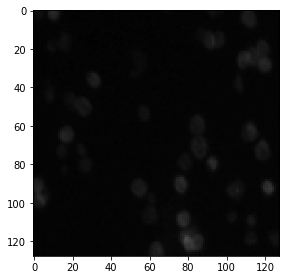

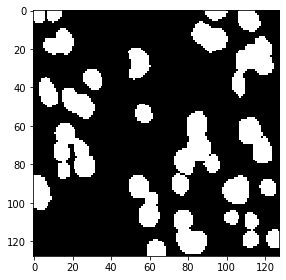

C:\Users\Admin\anaconda3\envs\gputest\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


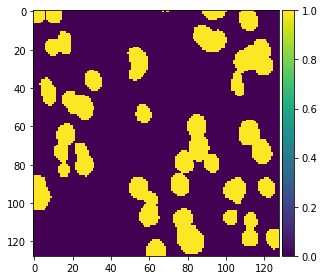

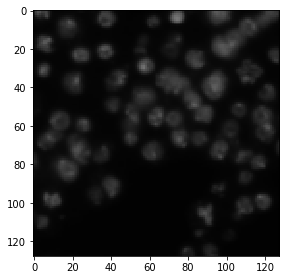

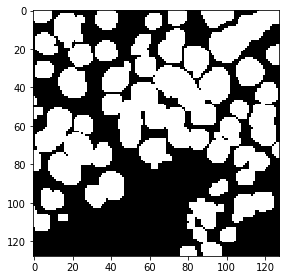

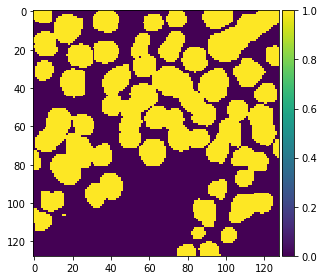

In [16]:

idx = random.randint(0, len(X_train))

preds_train = mod.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = mod.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = mod.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
